# Solution by Eduardo Silva (03805057)

# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

Using device: cpu
1001


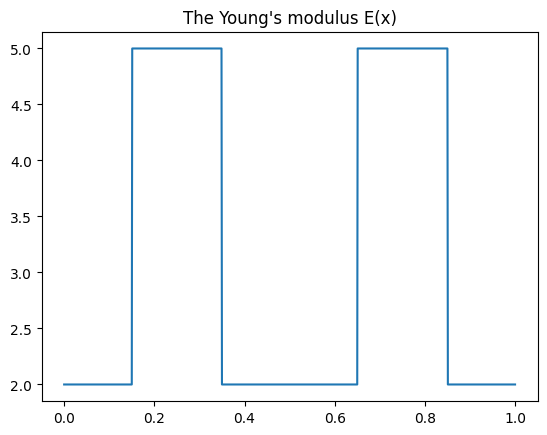

In [1]:
import numpy as np
import matplotlib.pyplot as  plt
import torch 
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# settings seeds so that it is possible to reproduce results
torch.manual_seed(43)
np.random.seed(43)



def E(x, phase1=2., phase2=5.):
    # I changed this funcntion to give a tensor so that it can be used by the model when training

    return torch.where(
        torch.abs(x - 0.5) < 0.35,
        torch.where(torch.abs(x - 0.5) > 0.15, torch.tensor(phase2), torch.tensor(phase1)),
        torch.tensor(phase1)
    )


x_image = np.linspace(0., 1., 1001)
x_image = torch.linspace(0, 1, 1001).reshape(-1, 1).requires_grad_(True)

e = E(x_image)
print(len(e))
#
plt.figure()
plt.plot(x_image.detach().numpy(),e.detach().numpy())
plt.title("The Young's modulus E(x)")
plt.show()

# 1) Loading the datapoints from the .h5 file

In [2]:
import h5py

with h5py.File("LinearElasticity1d.h5", "r") as f:
    print('The keys:', f.keys())
    x_test = np.array(f["x_test"])
    u_test = np.array(f["u_test"])

    if len(x_test) != len(u_test):
        # just maing sure the dataset is consistent
        print("Testing Dataset has different number of x and u points")
        raise AttributeError

print("Using number of test datapoints: ", len(x_test))
x_test = torch.tensor(x_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)

int_points = len(x_test)

The keys: <KeysViewHDF5 ['u_test', 'x_test']>
Using number of test datapoints:  1001


# 2) Defining Boundary Conditions, Integral Points, and Weights at Integral Points

In [3]:
#spatial boundaries
x_left, x_right = np.array([0.0 ]) , np.array([1.0 ])
x_boundaries = np.vstack([x_left, x_right]) # [[0.], [1.]]
x_boundaries = torch.tensor(x_boundaries, dtype=torch.float32)

# displacement boundaries, u(0) = u(1) = 0
u_boundaries = torch.tensor([[0.], [0.]], dtype=torch.float32)


In [4]:
#integral points
x_int, weights_int = np.polynomial.legendre.leggauss(int_points)
x_int, weights_int = x_int.reshape(-1, 1), weights_int.reshape(-1, 1)
x_int = torch.tensor(x_int, dtype=torch.float32)
weights_int = torch.tensor(weights_int, dtype=torch.float32)

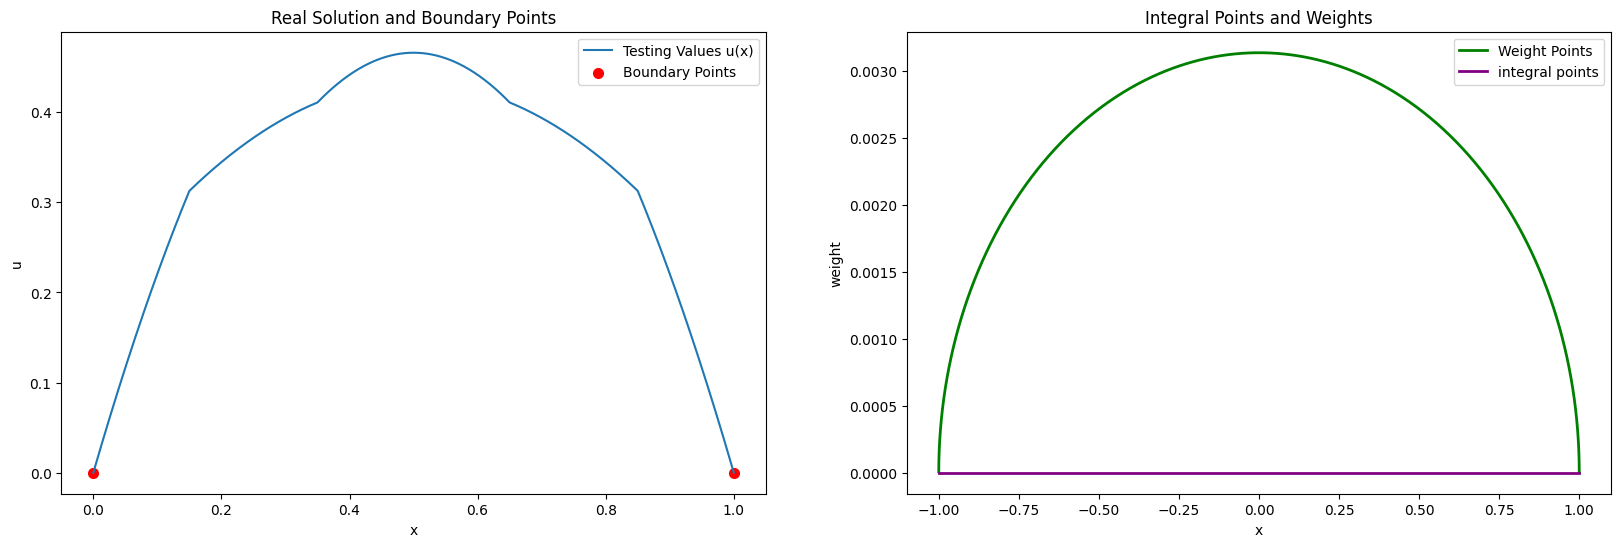

1001
1001


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
axes[0].plot(x_test, u_test, label='Testing Values u(x)')
axes[0].scatter(x_boundaries, u_boundaries, label='Boundary Points', linewidth=2, color = 'red')
axes[0].set_title('Real Solution and Boundary Points')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u')
axes[0].legend()
#
axes[1].plot(x_int, weights_int, label='Weight Points', linewidth=2, color = 'green')
axes[1].plot(x_int, torch.zeros_like(x_int), label='integral points', linewidth=2, color = 'purple')
axes[1].set_title('Integral Points and Weights')
axes[1].set_xlabel('x')
axes[1].set_ylabel('weight')
axes[1].legend()
#
plt.show()


print(len(x_test))
print(len(x_int))

# Deep Ritz Approach

The corresponding **variational problem** is given as:
$$
\min_{u\in \mathcal{U}} I(u) =\int_{\Omega} \left(\frac{1}{2}E(x)|\nabla u(x)|^2-f(x)u(x)\right) ~ dx 
$$

# 3) Class for MLP:

In [6]:
class GeneralMLP(nn.Module):

    def __init__(self, layers : list, dtype = torch.float32):

        super().__init__()

        model = []
        self.input = layers[0]
        for hidden in layers[1:]:
            model.append(nn.Linear(self.input, hidden, dtype=dtype))
            self.input = hidden

        self.model = nn.Sequential(*model)

    def activation(self, x):
        #using the activation function given in the lectures code for better performance
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x + torch.pi)
        return x

    def forward(self, x):
        # Forward through all but last layer
        for layer in self.model[:-1]:
            x = layer(x)
            x = self.activation(x)

        # Last layer without activation
        x = self.model[-1](x)
        return x

model = GeneralMLP([1, 40, 40, 40, 40, 1], dtype = torch.float32)
model = model.to(device)

print("USING THE FOLLOWING MODEL:\n")

summary(model, input_size=(1,))



USING THE FOLLOWING MODEL:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]              80
            Linear-2                   [-1, 40]           1,640
            Linear-3                   [-1, 40]           1,640
            Linear-4                   [-1, 40]           1,640
            Linear-5                    [-1, 1]              41
Total params: 5,041
Trainable params: 5,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


Initialization of Weights - Xavier Distribution

In [ ]:
def init_weights(m):
    # Xavier Initialization of Model's parameters (good practice to have generally)
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)


# 4) DataSet Class for Batching the Inputs

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, ax, u):
        self.ax = ax
        self.u = u

    def __len__(self):
        return self.ax.shape[0]

    def __getitem__(self, idx):
        ax = self.ax[idx]
        u = self.u[idx]
        return ax, u

# Creating DataLoader for Training Data
train_loader = DataLoader(MyDataset(x_int, weights_int), batch_size=len(x_int), shuffle=True)
for x_batch, w_batch in train_loader:
    print('x_batch shape:', x_batch.shape, 'w_batch shape:', w_batch.shape)
    break

x_batch shape: torch.Size([1001, 1]) w_batch shape: torch.Size([1001, 1])


# 5) Loss function:

The boundary condition loss:
$$
L_{bd} = \frac{1}{N_{bd}}\sum^{N_{bd}}_{i=1}|u_\theta(x_i)-u_{bd}(x_i)|^2.
$$

The PDE loss:
$$
L_{PDE}(\theta) = I[u_\theta] \approx \sum_{i=1}^{N_{int}} w_i \left( \frac{1}{2}E(x_i)|\nabla u_\theta(x_i)|^2 - f(x_i)u_\theta(x_i) \right).
$$

In [9]:
from torch.autograd import grad, Variable

# Usage of a Mollifier to implement boundary conditions for the U_Boundaries
# I do not use the E Boundaries for the Mollifier (explanation in report)
class Mollifier(object):

    def __init__(self):
        pass

    def apply_u_bd(self, u, x):
        #mollifier to apply BCS for u(x)
        # u(0) = u(1) = 0
        u = u * x * (1 - x)
        return u

class LossFunctionCalculation(object):

    def __init__(self, model_u, model_e = None, device = 'cpu'):

        self.device = device
        self.model_u = model_u
        self.model_e = model_e
        self.mollifier = Mollifier()
        self.getLoss = torch.nn.MSELoss()

    def loss_pde_DeepRitz(self, x_int, weights_int):

        # put the values of x in the right place after legendre
        x = x_int * 0.5 + 0.5

        # loss term related to the error satisfying the pde variational
        x = Variable(x, requires_grad=True).to(self.device)
        weights = weights_int.to(self.device)

        u = self.model_u(x)
        u = self.mollifier.apply_u_bd(u, x)

        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        Ex = E(x).to(self.device)

        fx = 9.81

        # The energy, varitional form of the PDE that we are using
        energy = torch.sum((0.5 * Ex * du_dx**2 - fx * u) * weights* 0.5 )

        return energy

    def loss_pde_PINNs_inverse(self, x_int, weights_int):
        #Function used to solve the inverse problem by calculating PINN residual
        x = x_int * 0.5 + 0.5
        x = Variable(x, requires_grad=True).to(self.device)
        weights = weights_int.to(self.device)

        u = self.model_u(x)
        E_pred = self.model_e(x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # no mollifiers here, to not create bias in inverse problem solution

        inter = E_pred * du_dx
        dinter_dx = grad(inputs=x, outputs=inter, grad_outputs=torch.ones_like(inter), create_graph=True)[0]

        fx = 9.81

        #PINN Residual
        residual = (-dinter_dx - fx) * weights * 0.5
        loss_residual_PINN = self.getLoss(residual, torch.zeros_like(residual))

        return loss_residual_PINN

    def loss_bc_E(self, x_boundaries):
        #Calculate the loss at boundaries for E(x)
        x_bds = x_boundaries.to(self.device)
        E_pred = self.model_e(x_bds)

        loss_E_bc = self.getLoss(E_pred, torch.ones_like(E_pred))

        return loss_E_bc

    def loss_bc_U(self, x_boundaries):
        x_bds = x_boundaries.to(self.device)
        u_pred = self.model_u(x_bds)

        loss_U_bc = self.getLoss(u_pred, torch.zeros_like(u_pred))

        return loss_U_bc

    def loss_data(self, x_obs, u_obs):
        #Calculate the loss for fitting the u_obs data

        x = x_obs.to(self.device)

        u = self.model_u(x)

        loss = self.getLoss(u, u_obs.to(self.device))

        return loss

    def get_error(self, x_test, u_test):
        # using mollifier for forward problem
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.model_u(x_test)
        u = self.mollifier.apply_u_bd(u, x_test)

        u = u.view(-1)
        u_test = u_test.view(-1)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

    def get_error_E(self, x_test, e_test):
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e_pred = self.model_e(x_test)

        e_pred = e_pred.view(-1)
        e_test = e_test.view(-1)

        return torch.sqrt(torch.sum((e_pred-e_test)**2)/torch.sum(e_test**2))

    def get_error_U(self, x_test, u_test):

        # without using mollifier for inverse problem
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.model_u(x_test)

        u = u.view(-1)
        u_test = u_test.view(-1)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))



# 6) Training Process:

In [10]:
from tqdm import trange
#
epochs = 5000
lr = 1e-3
model_u = GeneralMLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
#model_u.apply(init_weights)
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/6), gamma=0.5)
lossClass = LossFunctionCalculation(model_u, None, device=device)


############ The training process
error_list = []
lost_list = []

for epoch in trange(epochs):

    batching_loss = 0

    for x_batch, w_batch in train_loader:

    #print("TRAIN")
    ############# Calculate losses
        loss_train = lossClass.loss_pde_DeepRitz(x_batch, w_batch)
        batching_loss += loss_train.item()
        #
        optimizer.zero_grad()
        loss_train.backward()

        # weights clipping to prevent gradients exploding in model
        #torch.nn.utils.clip_grad_norm_(model_u.parameters(), max_norm=1.0)

        optimizer.step()

    lost_list.append(batching_loss / len(train_loader))

    #
    #print("TEST")
    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())

    #
    scheduler.step()  # Adjust learning rate
        
    if (epoch+1)%500==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list[-1])
        # not using pop to not loose the last value of error_list

 10%|█         | 509/5000 [00:10<01:29, 50.21it/s]

Epoch:499, The loss is:-1.613229751586914, lr: 0.001
0.009124805219471455


 20%|██        | 1007/5000 [00:18<01:03, 63.17it/s]

Epoch:999, The loss is:-1.6170119047164917, lr: 0.0005
0.0059930807910859585


 30%|███       | 1508/5000 [00:27<00:56, 62.15it/s]

Epoch:1499, The loss is:-1.6184523105621338, lr: 0.0005
0.00485655153170228


 40%|████      | 2008/5000 [00:35<00:51, 57.95it/s]

Epoch:1999, The loss is:-1.6192872524261475, lr: 0.00025
0.004225987941026688


 50%|█████     | 2508/5000 [00:46<00:44, 55.87it/s]

Epoch:2499, The loss is:-1.6202034950256348, lr: 0.000125
0.0034979081247001886


 60%|██████    | 3010/5000 [00:55<00:32, 61.51it/s]

Epoch:2999, The loss is:-1.6205365657806396, lr: 0.000125
0.00321922916918993


 70%|███████   | 3513/5000 [01:03<00:24, 61.57it/s]

Epoch:3499, The loss is:-1.6207958459854126, lr: 6.25e-05
0.0030003092251718044


 80%|████████  | 4006/5000 [01:12<00:17, 57.23it/s]

Epoch:3999, The loss is:-1.6209683418273926, lr: 6.25e-05
0.0028512459248304367


 90%|█████████ | 4511/5000 [01:23<00:08, 54.52it/s]

Epoch:4499, The loss is:-1.6210901737213135, lr: 3.125e-05
0.0027377598453313112


100%|██████████| 5000/5000 [01:31<00:00, 54.59it/s]

Epoch:4999, The loss is:-1.621183156967163, lr: 1.5625e-05
0.0026442017406225204


# 7) Confirmation and Validation of Results

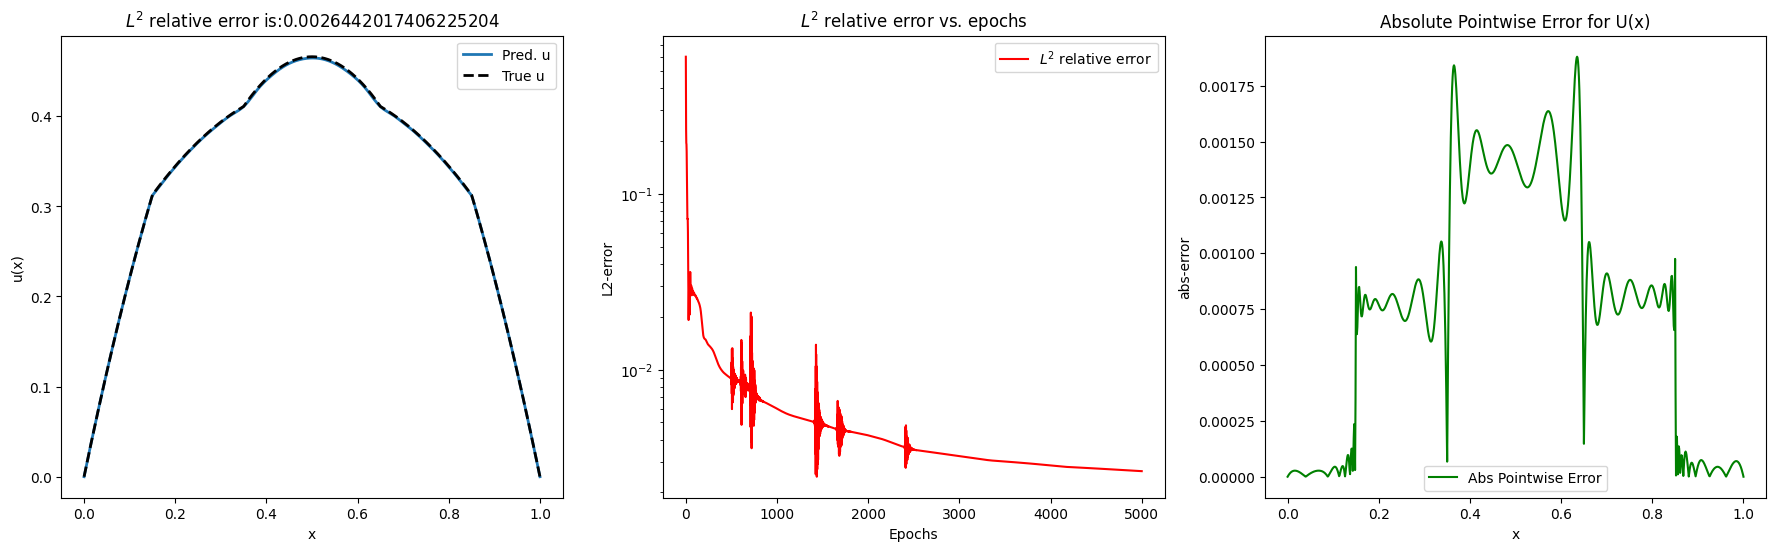

tensor(0.0026)


In [11]:
x_query = np.linspace(x_left, x_right, 1001)
x_query = torch.tensor(x_query, dtype=torch.float32)
#
u_query = model_u(x_query.to(device)).detach().cpu()
u_query = lossClass.mollifier.apply_u_bd(u_query, x_query)

u_query = u_query.view(-1)
u_test = u_test.view(-1)

error = torch.sqrt(torch.sum((u_test-u_query)**2)/torch.sum(u_test**2))
#
fig, axes = plt.subplots(1, 3, figsize=(22,6))
axes[0].plot(x_query, u_query, label='Pred. u', linewidth = 2)
axes[0].plot(x_query, u_test, '--', label='True u', linewidth=2, color = 'black')
axes[0].set_title(f'$L^2$ relative error is:{error}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].legend()
#
axes[1].semilogy(error_list, label='$L^2$ relative error', color = 'red')
axes[1].set_title('$L^2$ relative error vs. epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('L2-error')
axes[1].legend()
#
axes[2].plot(x_query, abs(u_query - u_test), label='Abs Pointwise Error', color = 'green')
axes[2].set_title(f"Absolute Pointwise Error for U(x)")
axes[2].set_xlabel('x')
axes[2].set_ylabel('abs-error')
axes[2].legend()

#
plt.show()


# making sure that the error is the same as manually calculating it
sum_u = 0
for i in u_test:
    sum_u += i**2

sum_u_u = 0
for j in range(len(u_query)):
    sum_u_u += (u_query[j] - u_test[j])**2

final_error = torch.sqrt(sum_u_u / sum_u)
print(final_error)


## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

# 1) Data Processing

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>


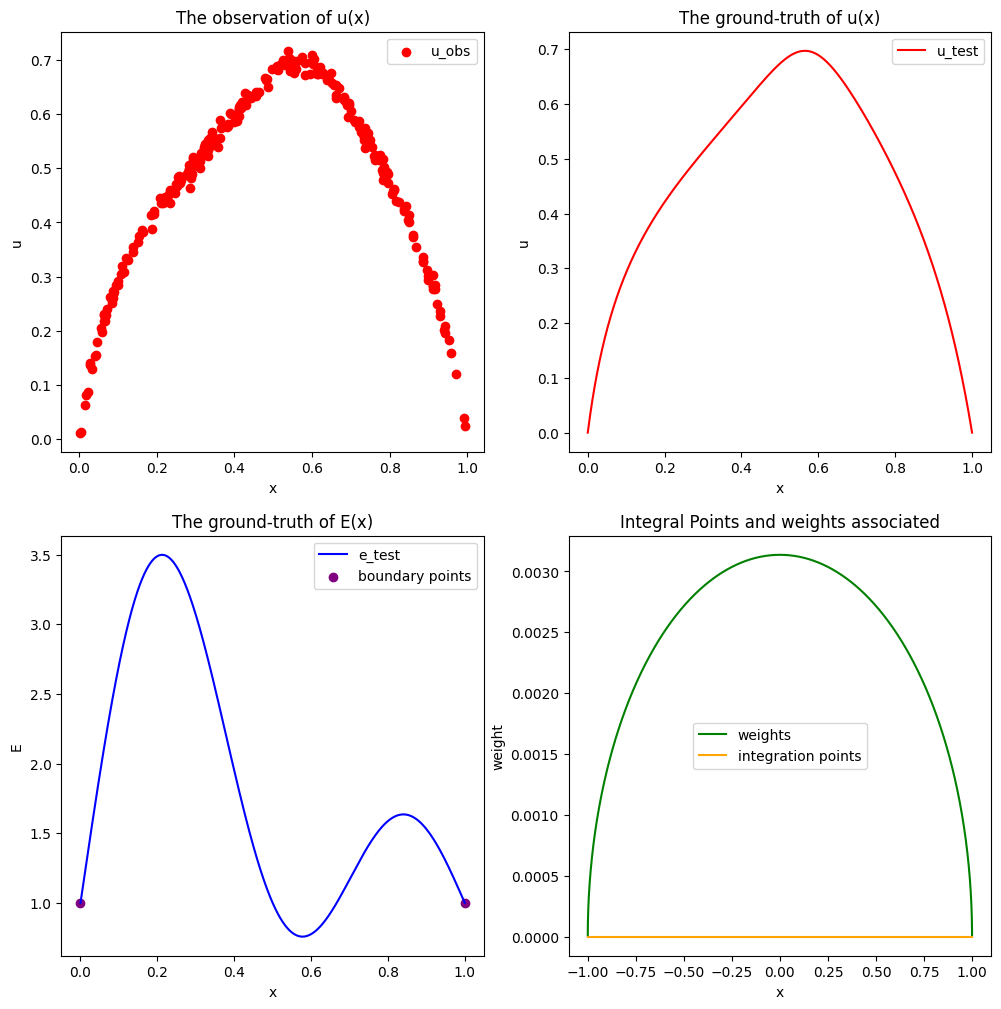

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad, Variable
from tqdm import trange
#
with h5py.File('LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs = torch.tensor(np.array(file['x_obs']).reshape(-1,1), dtype=torch.float32)
    u_obs = torch.tensor(np.array(file['u_obs']).reshape(-1,1), dtype=torch.float32)
    x_test = torch.tensor(np.array(file['x_test']).reshape(-1,1), dtype=torch.float32)
    e_test = torch.tensor(np.array(file['e_test']).reshape(-1,1), dtype=torch.float32)
    u_test = torch.tensor(np.array(file['u_test']).reshape(-1,1), dtype=torch.float32)

#

int_points = len(x_test)

# Integration Points and Weights
x_int, weights_int = np.polynomial.legendre.leggauss(int_points)
x_int, weights_int = x_int.reshape(-1, 1), weights_int.reshape(-1, 1)
x_int = torch.tensor(x_int, dtype=torch.float32)
weights_int = torch.tensor(weights_int, dtype=torch.float32)

# Boundary Conditions
lb, rb = [0.], [1.]

x_boundaries = np.vstack([np.array(lb), np.array(rb)])
x_boundaries = torch.tensor(x_boundaries, dtype=torch.float32)

fig, axes = plt.subplots(2, 2, figsize=(12,12))

axes[0][0].scatter(x_obs, u_obs, label='u_obs', color = 'r')
axes[0][0].set_title('The observation of u(x)')
axes[0][0].set_xlabel('x')
axes[0][0].set_ylabel('u')
axes[0][0].legend()
#

axes[0][1].plot(x_test, u_test, label='u_test', color = 'r')
axes[0][1].set_title('The ground-truth of u(x)')
axes[0][1].set_xlabel('x')
axes[0][1].set_ylabel('u')
axes[0][1].legend()
#

axes[1][0].plot(x_test, e_test, label='e_test', color = 'b')
axes[1][0].scatter(x_boundaries, [1, 1], label = 'boundary points', color = 'purple')
axes[1][0].set_title('The ground-truth of E(x)')
axes[1][0].set_xlabel('x')
axes[1][0].set_ylabel('E')
axes[1][0].legend()
#

axes[1][1].plot(x_int, weights_int, label='weights', color = 'g')
axes[1][1].plot(x_int, torch.zeros_like(x_int), label = 'integration points', color = 'orange')
axes[1][1].set_title('Integral Points and weights associated')
axes[1][1].set_xlabel('x')
axes[1][1].set_ylabel('weight')
axes[1][1].legend()
plt.show()


# 2) Training Process

In [ ]:
model_u = GeneralMLP([1, 128, 128, 128, 128, 1]).to(device)
model_e = GeneralMLP([1, 128, 128, 128, 128, 1]).to(device)

# Xavier Initialization Not Used since it led to worse results
#model_u.apply(init_weights)
#model_e.apply(init_weights)

train_loader = DataLoader(MyDataset(x_int, weights_int), batch_size=len(x_int), shuffle=True)
for x_batch, w_batch in train_loader:
    print('x_batch shape:', x_batch.shape, 'w_batch shape:', w_batch.shape)
    break


epochs = 10000

optimizer = torch.optim.Adam(
    params=list(model_e.parameters()) + list(model_u.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/10), gamma=0.5)

w_data = 10.
w_pde  = 500.
w_e_bc = 1.
w_u_bc = 1.


loss_fn = LossFunctionCalculation(model_u, model_e, device=device)

error_list_data = []
error_list_pde = []
error_list_total = []
error_list_bd = []

error_list_U = []
error_list_E = []

for epoch in trange(epochs):

    batching_loss = 0

    for x_batch, w_batch in train_loader:


        loss_pde = loss_fn.loss_pde_PINNs_inverse(x_batch, w_batch)
        loss_data = loss_fn.loss_data(x_obs, u_obs)
        loss_e_bds = loss_fn.loss_bc_E(x_boundaries)
        loss_u_bds = loss_fn.loss_bc_U(x_boundaries)


        total_loss = w_pde * loss_pde + w_data * loss_data  + w_e_bc * loss_e_bds + w_u_bc * loss_u_bds # you can weigh them differently if needed

        batching_loss += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()

        # weights clipping to prevent gradients exploding in model
        # in this case weight clipping showed better results
        torch.nn.utils.clip_grad_norm_(model_u.parameters(), max_norm=1.0)

        optimizer.step()


    with torch.no_grad():
        error_list_data.append(loss_data.item())
        error_list_pde.append(loss_pde.item())
        error_list_bd.append(loss_e_bds.item())
        error_list_total.append(total_loss.item())

        error_U = loss_fn.get_error_U(x_test, u_test)
        error_list_U.append(error_U.item())

        error_E = loss_fn.get_error_E(x_test, e_test)
        error_list_E.append(error_E.item())

    scheduler.step()


    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss Obs: {loss_data.item():.4e}, Loss PDE: {loss_pde.item():.4e}")
        #print(f"Epoch {epoch+1},  Loss PDE: {loss_pde.item():.4e}")
        print(f"Total loss: {total_loss}")





x_batch shape: torch.Size([1001, 1]) w_batch shape: torch.Size([1001, 1])


  5%|▌         | 503/10000 [00:38<11:04, 14.30it/s]  

Epoch 500, Loss Obs: 3.3901e-04, Loss PDE: 4.9675e-06
Total loss: 0.00606752373278141


 10%|█         | 1001/10000 [01:15<11:04, 13.54it/s] 

Epoch 1000, Loss Obs: 1.3011e-04, Loss PDE: 6.1030e-07
Total loss: 0.0016790272202342749


 15%|█▌        | 1503/10000 [01:52<09:32, 14.84it/s]

Epoch 1500, Loss Obs: 9.5074e-05, Loss PDE: 1.6371e-07
Total loss: 0.0010436425218358636


 20%|██        | 2001/10000 [02:30<09:19, 14.30it/s]

Epoch 2000, Loss Obs: 9.3952e-05, Loss PDE: 5.6170e-08
Total loss: 0.000976861221715808


 25%|██▌       | 2503/10000 [03:07<08:24, 14.86it/s]

Epoch 2500, Loss Obs: 9.3840e-05, Loss PDE: 3.6222e-08
Total loss: 0.0009651776636019349


 30%|███       | 3001/10000 [03:52<10:48, 10.80it/s]

Epoch 3000, Loss Obs: 9.3772e-05, Loss PDE: 2.4718e-08
Total loss: 0.0009581472259014845


 35%|███▌      | 3501/10000 [04:34<07:45, 13.95it/s]

Epoch 3500, Loss Obs: 9.3737e-05, Loss PDE: 2.0827e-08
Total loss: 0.0009555139695294201


 40%|████      | 4001/10000 [05:13<07:22, 13.57it/s]

Epoch 4000, Loss Obs: 9.3697e-05, Loss PDE: 1.7640e-08
Total loss: 0.0009531519608572125


 45%|████▌     | 4501/10000 [05:52<06:32, 14.00it/s]

Epoch 4500, Loss Obs: 9.3676e-05, Loss PDE: 1.6208e-08
Total loss: 0.0009520111489109695


 50%|█████     | 5001/10000 [06:33<06:16, 13.27it/s]

Epoch 5000, Loss Obs: 9.3651e-05, Loss PDE: 1.4785e-08
Total loss: 0.000950818823184818


 55%|█████▌    | 5502/10000 [07:18<05:49, 12.88it/s]

Epoch 5500, Loss Obs: 9.3638e-05, Loss PDE: 1.4044e-08
Total loss: 0.0009501769673079252


 60%|██████    | 6001/10000 [08:06<05:52, 11.35it/s]

Epoch 6000, Loss Obs: 9.3622e-05, Loss PDE: 1.3228e-08
Total loss: 0.0009494549012742937


 65%|██████▌   | 6501/10000 [08:52<05:42, 10.21it/s]

Epoch 6500, Loss Obs: 9.3614e-05, Loss PDE: 1.2771e-08
Total loss: 0.000949040986597538


 70%|███████   | 7001/10000 [09:38<04:13, 11.81it/s]

Epoch 7000, Loss Obs: 9.3602e-05, Loss PDE: 1.2246e-08
Total loss: 0.0009485529153607786


 75%|███████▌  | 7502/10000 [10:28<03:26, 12.09it/s]

Epoch 7500, Loss Obs: 9.3595e-05, Loss PDE: 1.1936e-08
Total loss: 0.0009482636232860386


 80%|████████  | 8001/10000 [11:16<03:22,  9.86it/s]

Epoch 8000, Loss Obs: 9.3587e-05, Loss PDE: 1.1575e-08
Total loss: 0.0009479230502620339


 85%|████████▌ | 8501/10000 [12:02<02:06, 11.89it/s]

Epoch 8500, Loss Obs: 9.3582e-05, Loss PDE: 1.1358e-08
Total loss: 0.0009477165876887739


 90%|█████████ | 9002/10000 [12:48<01:19, 12.57it/s]

Epoch 9000, Loss Obs: 9.3576e-05, Loss PDE: 1.1102e-08
Total loss: 0.000947472988627851


 95%|█████████▌| 9501/10000 [13:41<00:40, 12.21it/s]

Epoch 9500, Loss Obs: 9.3573e-05, Loss PDE: 1.0949e-08
Total loss: 0.0009473245590925217


100%|██████████| 10000/10000 [14:26<00:00, 11.54it/s]

Epoch 10000, Loss Obs: 9.3568e-05, Loss PDE: 1.0768e-08
Total loss: 0.0009471498196944594


# 3) Visualization of Results

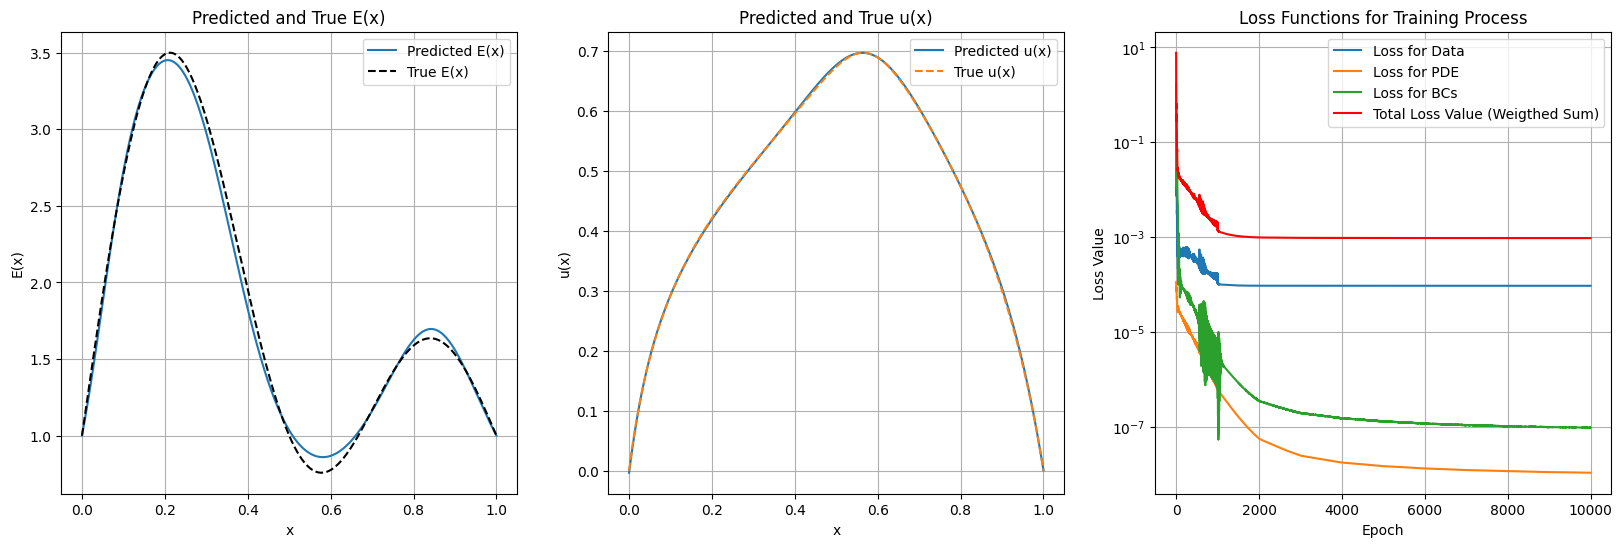

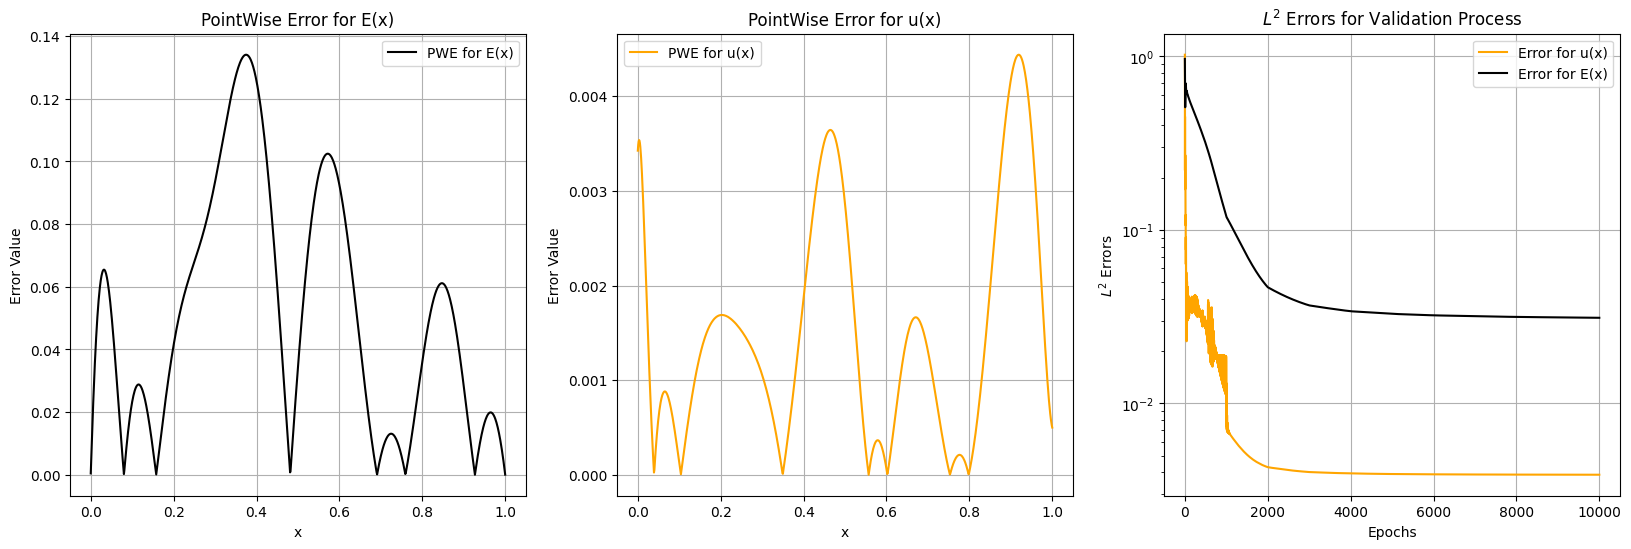

In [14]:
with torch.no_grad():
    e_pred = model_e(x_test.to(device)).detach().cpu()
    u_pred = model_u(x_test.to(device)).detach().cpu()


fig, axes = plt.subplots(1, 3, figsize=(20,6))

axes[0].plot(x_test, e_pred, label='Predicted E(x)')
axes[0].plot(x_test, e_test,'--', label='True E(x)', color = 'black')
axes[0].set_title('Predicted and True E(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('E(x)')
axes[0].legend()
axes[0].grid()

axes[1].plot(x_test, u_pred, label='Predicted u(x)')
axes[1].plot(x_test, u_test,'--',label='True u(x)')
axes[1].set_title('Predicted and True u(x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x)')
axes[1].legend()
axes[1].grid()

epoch_plot = np.linspace(0, epochs, epochs)

axes[2].semilogy(epoch_plot, error_list_data, label='Loss for Data')
axes[2].semilogy(epoch_plot, error_list_pde, label='Loss for PDE')
axes[2].semilogy(epoch_plot, error_list_bd, label = 'Loss for BCs')
axes[2].semilogy(epoch_plot, error_list_total, label = 'Total Loss Value (Weigthed Sum)', color = 'r')
axes[2].set_title('Loss Functions for Training Process')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss Value')
axes[2].legend()
axes[2].grid()


plt.show()


fig2, axes2 = plt.subplots(1, 3, figsize=(20,6))

axes2[0].plot(x_test, abs(e_test-e_pred), label='PWE for E(x)', color = 'black')
axes2[0].set_title('PointWise Error for E(x)')
axes2[0].set_xlabel('x')
axes2[0].set_ylabel('Error Value')
axes2[0].legend()
axes2[0].grid()

axes2[1].plot(x_test, abs(u_test-u_pred), label='PWE for u(x)', color = 'orange')
axes2[1].set_title('PointWise Error for u(x)')
axes2[1].set_xlabel('x')
axes2[1].set_ylabel('Error Value')
axes2[1].legend()
axes2[1].grid()

axes2[2].semilogy(error_list_U, label='Error for u(x)', color = 'orange')
axes2[2].semilogy(error_list_E, label='Error for E(x)', color = 'black')
axes2[2].set_title('$L^2$ Errors for Validation Process')
axes2[2].set_xlabel('Epochs')
axes2[2].set_ylabel('$L^2$ Errors')
axes2[2].legend()
axes2[2].grid()

plt.show()




